# Проект: Обучение с учителем: качество модели

# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Загрузка данных и необходмых библиотек

### Сначала загрузим необходимые библиотеки

In [1]:
!pip install -q imblearn
!pip install -q phik
!pip install -q scikit-learn
!pip install -q shap
!pip install -q optuna
!pip install -q optuna.integration

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats
import optuna
import phik
import shap


#Графики
import seaborn as sns
import matplotlib.pyplot as plt
from re import template
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import shapiro
from phik.report import plot_correlation_matrix




# Модели МО
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# Разбивка данных + обработка признаков 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


# Метрики для Линейной Регрессии
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


# Метрики для Логистической Регрессии
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn. metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score

# Для подбора гиперпараметров 
from optuna import distributions
from optuna.integration import OptunaSearchCV

# Интерпритация модели
from sklearn.inspection import permutation_importance



# Для создания пайплайна 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
# Сразу зададим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# Загрузим файлы
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")

### Изучим данные в каждом датасете

In [5]:
market_file.sample(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
99,215447,Снизилась,стандарт,да,2.4,5,511,0.94,Товары для детей,3,2,3,3
821,216169,Прежний уровень,премиум,да,4.1,3,748,0.13,Мелкая бытовая техника и электроника,3,1,5,6
652,216000,Прежний уровень,стандарт,да,3.3,5,372,0.25,Кухонная посуда,2,2,5,8
499,215847,Прежний уровень,стандарт,да,4.7,5,966,0.15,Товары для детей,3,1,8,15
874,216222,Прежний уровень,стандарт,да,4.7,4,451,0.18,Товары для детей,5,4,5,8


In [6]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [7]:
market_money.sample(5)

,id,Период,Выручка
677,215573,препредыдущий_месяц,4671.0
3278,216440,предыдущий_месяц,4318.0
3796,216613,препредыдущий_месяц,4788.0
3159,216401,предыдущий_месяц,5364.5
1367,215803,препредыдущий_месяц,5273.0


In [8]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

In [9]:
market_time.sample(5)

,id,Период,минут
1390,216043,текущий_месяц,12
2248,216472,текущий_месяц,10
580,215638,текущий_месяц,12
2243,216469,предыдцщий_месяц,23
486,215591,текущий_месяц,7


In [10]:
market_time.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

In [11]:
money.sample(5)

,id,Прибыль
738,216086,2.66
271,215619,5.12
107,215455,2.53
921,216269,4.75
764,216112,5.14


In [12]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

#### Вывод: Данные на первый взгляд не вызывают сомнений. В данных нет пропусков. Необходмио осуществить предобработку данных.

## Предобработка данных

### Приведем к единообразию названия столбцов, обработаем  дубликаты.

In [13]:
# Столбцы - напишем функцию: пробелы на '_' и все к нижнему регистру


In [14]:
def columns_str(arr):
    for df in arr:
        df.columns = df.columns.str.replace(' ', '_').str.lower()

In [15]:
#создадим массив датафреймов
arr = [market_file,market_money,market_time,money]

In [16]:
columns_str(arr)

In [17]:
# проверим рандомный файл
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [18]:
#C типом данных вопросов при знакомстве не возникло, почистим дубли:
def find_double(arr):
    for df in arr: 
        print(df.duplicated().sum())

In [19]:
find_double(arr)

0
0
0
0


In [20]:
# В каждом датасете есть столбцы с категорией, где возможны ошибки. Посмотрим их:
def cat_col_uniq(arr):
    for df in arr:
        cat_col_names = df.select_dtypes(exclude='number').columns.tolist()
        for col in cat_col_names:
            print(df[col].unique())

In [21]:
cat_col_uniq(arr)

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
['текущий_месяц' 'предыдцщий_месяц']


In [22]:
# видим две ошибки, сейчас поправим: 
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')


In [23]:
# на всякий проверим не появилось ли дубликатов
find_double(arr)

0
0
0
0


### Вывод: 
- Привели все столбцы к единообразию
- Убрали ошибку в категориях
- Убедились что нет дубликатов 
- Можно приступать к следующему шагу 


## Исследовательский анализ данных


### С прошлого задания у меня было две фунцкии - для количественных и категориальных признаков. Добавим разбивку по целевому признаку в количествеенному и посмотрим.


In [24]:
def analyze_numerical_features(df, features, target=None):
    for feature in features:
        print(f"📊 Статистика для признака: {feature}")
        display(df[feature].describe())
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Гистограмма
        axes[0].set_title(f'Распределение {feature}', fontsize=14)
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Количество')

        if target:
            sns.histplot(data=df, x=feature, hue=target, kde=True, bins=20, ax=axes[0])
        else:
            sns.histplot(data=df, x=feature, kde=True, bins=20, ax=axes[0])
        
        # Boxplot
        axes[1].set_title(f'Boxplot для {feature}', fontsize=14)
        if target:
            sns.boxplot(data=df, x=target, y=feature, ax=axes[1])
        else:
            sns.boxplot(data=df, x=feature, ax=axes[1])
        
        plt.tight_layout()
        plt.show()
        print("-" * 60)

In [25]:
#для категориальных
def analyze_categorical_features(df, features):
    for feature in features:
        print(f"Числовые данные для {feature}:")
        display(df[feature].value_counts())
        
        plt.figure(figsize=(8, 4))
        sns.countplot(y=df[feature], order=df[feature].value_counts().index)
        plt.title(f"Распределение категорий {feature}")
        plt.show()
        print("-" * 50)

In [26]:
# добавим функцию для дискретных величин
def analyze_discrete_features(df, features, target=None):
    for feature in features:
        print(f"📊 Статистика по дискретному признаку: {feature}")
        display(df[feature].value_counts().sort_index())
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))


        if target:
            sns.countplot(data=df, x=feature, hue=target,
                          order=sorted(df[feature].dropna().unique()),
                          ax=axes[0])
        else:
            sns.countplot(data=df, x=feature,
                          order=sorted(df[feature].dropna().unique()),
                          ax=axes[0])
        # меняем распределение значений — countplot
        axes[0].set_title(f'Распределение значений {feature}', fontsize=14)
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Количество')
            
        axes[0].tick_params(axis='x')

        # ящик с усами по target ))
        axes[1].set_title(f'Boxplot: {feature} по целевому признаку', fontsize=14)
        if target:
            sns.boxplot(data=df, x=target, y=feature, ax=axes[1])
        else:
            sns.boxplot(data=df, y=feature, ax=axes[1])
        
        plt.tight_layout()
        plt.show()
        print("-" * 60)


In [27]:
# Добавил тест Шапиро-Уилка
def norm_test_all(data, features, alpha=0.05):
    for feature in features:
        print(f"\n📊 Анализ признака: {feature}")
        
        # Тест Шапиро-Уилка
        stat, p = stats.shapiro(data[feature].dropna())
        print(f"Shapiro-Wilk test: stat={stat:.3f}, p-value={p:.3f}")
        if p > alpha:
            print("✅ Распределение похоже на нормальное (не отвергаем H0)")
        else:
            print("❌ Распределение отличается от нормального (отвергаем H0)")
        
        # Построим графики
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        sns.histplot(data[feature].dropna(), kde=True, ax=axs[0])
        axs[0].set_title('Гистограмма')
        axs[0].set_ylabel('Частота')
        axs[0].set_xlabel(feature)

        stats.probplot(data[feature].dropna(), dist='norm', plot=axs[1])
        axs[1].set_title('Q-Q plot')

        plt.suptitle(f'Анализ признака: {feature}', fontsize=14)
        plt.tight_layout()
        plt.show()

### Будем анализировать датасеты по порядку, сначала market_file

In [28]:
#соберем все количественные из основного датафрейма
quant_features = [ 
       'маркет_актив_6_мес',  'длительность',
       'акционные_покупки',
        'ошибка_сервиса',
       'страниц_за_визит']

In [29]:
market_file['неоплаченные_продукты_штук_квартал'].unique()

array([ 2,  4,  0,  1,  3,  5,  8,  6,  9, 10,  7])

In [30]:
# Значений, конечно, многовато. Но на график думаю влезет.

In [31]:
#Соберем все количественные, но с дискретной природой: 
discrete_features = [
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
]

In [32]:
#и категориальные
cat_features = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
               'популярная_категория']


📊 Статистика для признака: маркет_актив_6_мес


count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

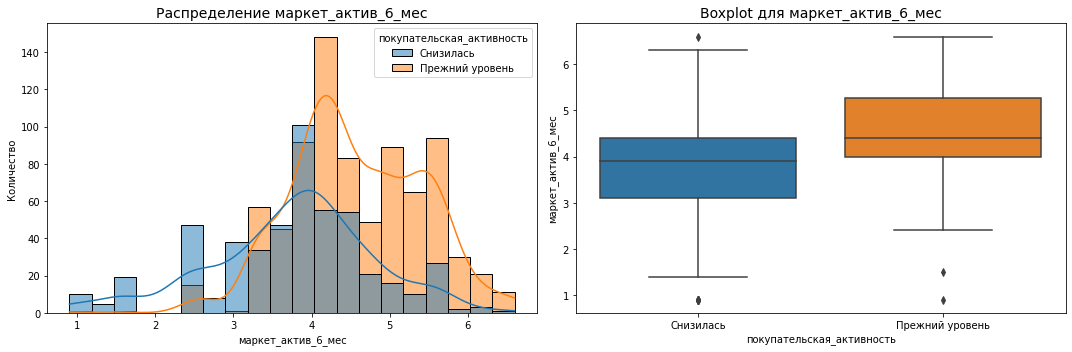

------------------------------------------------------------
📊 Статистика для признака: длительность


count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

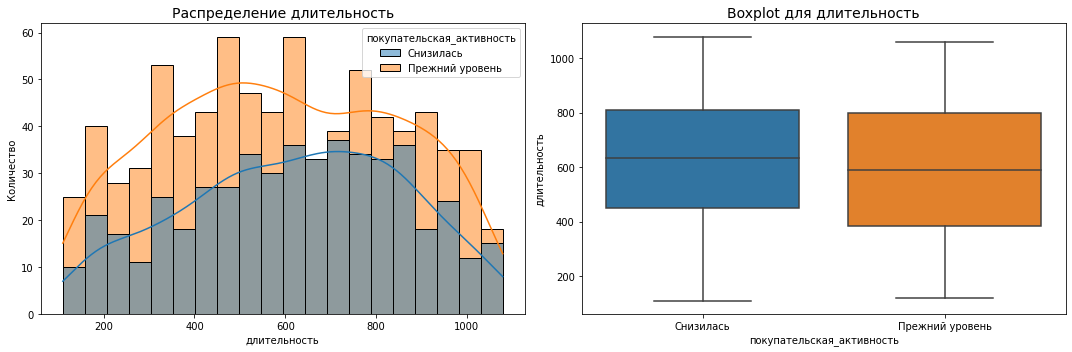

------------------------------------------------------------
📊 Статистика для признака: акционные_покупки


count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

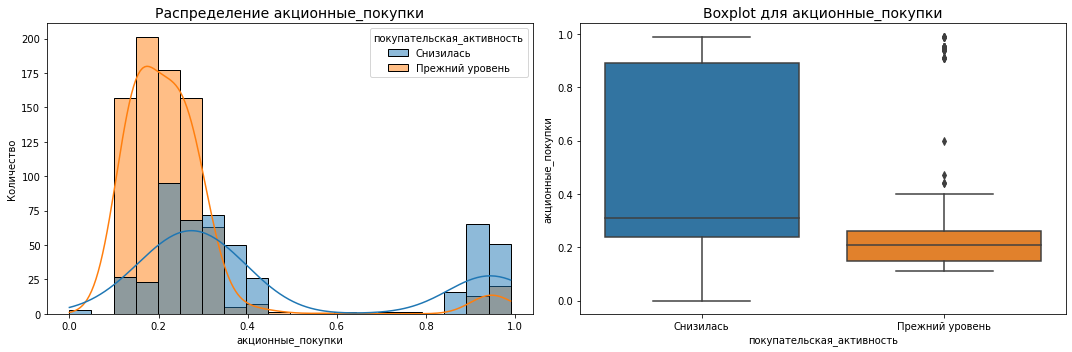

------------------------------------------------------------
📊 Статистика для признака: ошибка_сервиса


count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

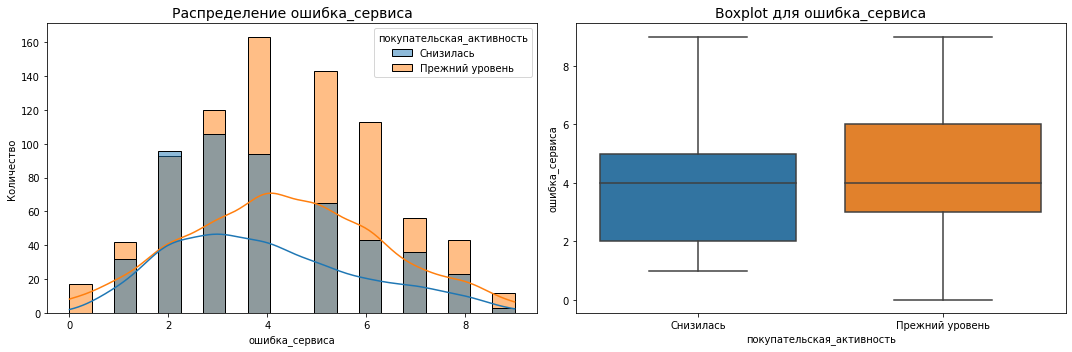

------------------------------------------------------------
📊 Статистика для признака: страниц_за_визит


count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

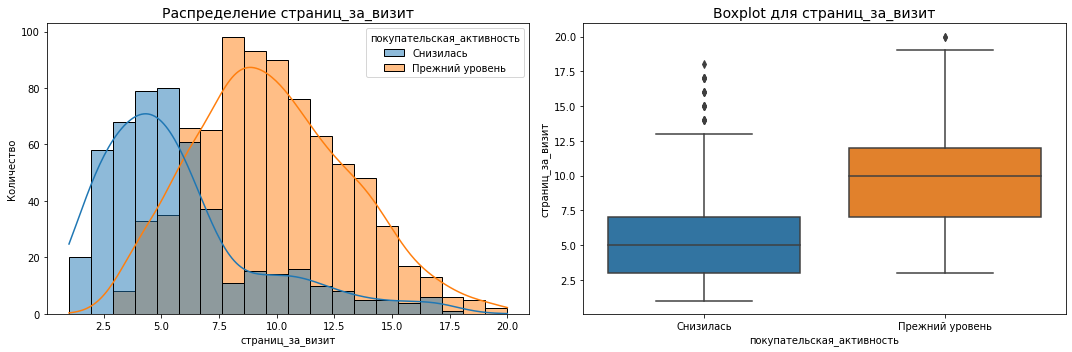

------------------------------------------------------------


In [33]:
#запускаем количественные на основном датафрейме
analyze_numerical_features(market_file, quant_features,'покупательская_активность')

📊 Статистика по дискретному признаку: маркет_актив_тек_мес


3    308
4    669
5    323
Name: маркет_актив_тек_мес, dtype: int64

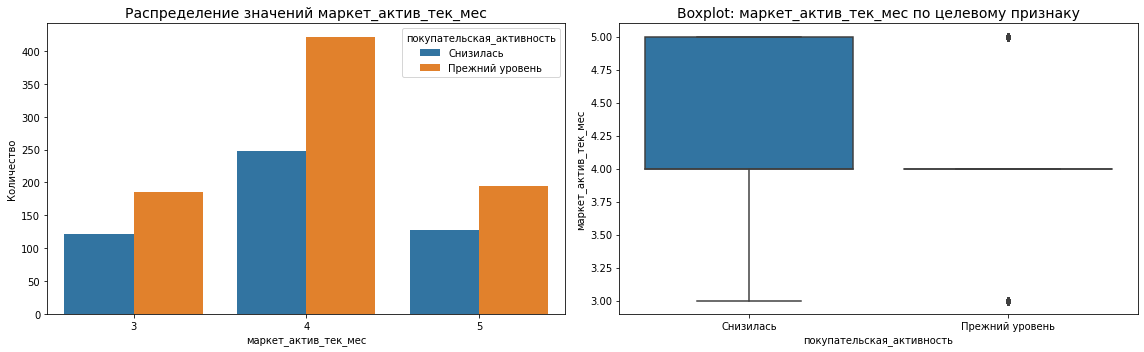

------------------------------------------------------------
📊 Статистика по дискретному признаку: средний_просмотр_категорий_за_визит


1    106
2    312
3    356
4    263
5    177
6     86
Name: средний_просмотр_категорий_за_визит, dtype: int64

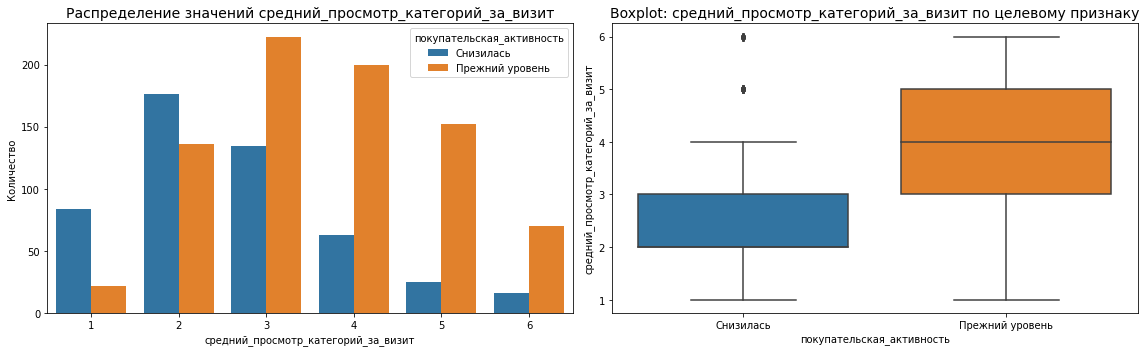

------------------------------------------------------------
📊 Статистика по дискретному признаку: неоплаченные_продукты_штук_квартал


0     116
1     261
2     261
3     218
4     197
5     135
6      44
7      34
8      20
9      10
10      4
Name: неоплаченные_продукты_штук_квартал, dtype: int64

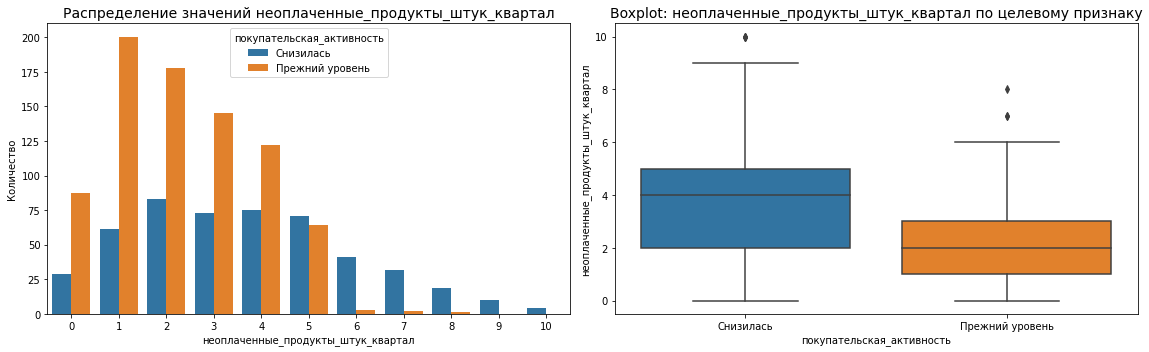

------------------------------------------------------------


In [34]:
# посмотрим теперь на графики
analyze_discrete_features(market_file, discrete_features, target='покупательская_активность')

### Вывод по дискретным признакам: 
- Видно что с клиентами, у которых покупательская активность на прежднем уровне,количество макретинговых коммуникаций за текущий месяц выше.
- Клиенты с актвиной покупательской активностью смотрят больше категорий за визит. Это может быть определенным маркером для бизнеса.
- При этом количество неоплаченных товаров можно расценивать по разному. Однако после 6шт, покупательская активность сильно идет на спад.

Числовые данные для покупательская_активность:


Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

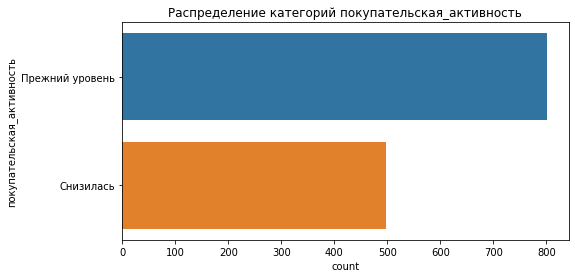

--------------------------------------------------
Числовые данные для тип_сервиса:


стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

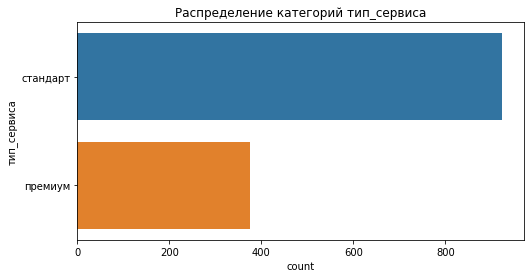

--------------------------------------------------
Числовые данные для разрешить_сообщать:


да     962
нет    338
Name: разрешить_сообщать, dtype: int64

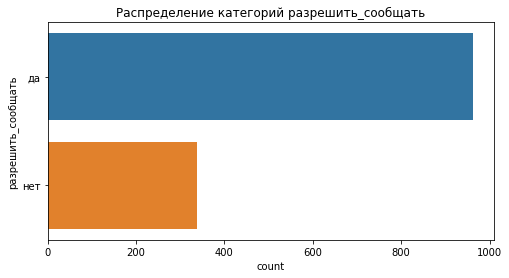

--------------------------------------------------
Числовые данные для популярная_категория:


Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

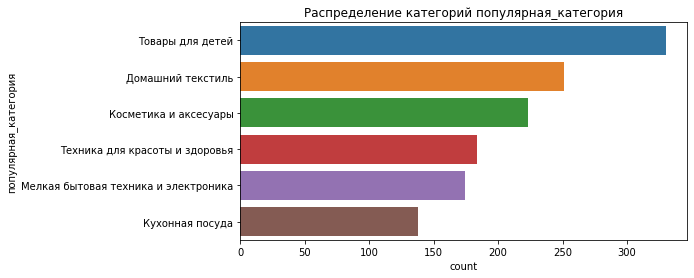

--------------------------------------------------


In [35]:
analyze_categorical_features(market_file, cat_features)


### Теперь market_money.csv

In [36]:
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

📊 Статистика для признака: выручка


count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

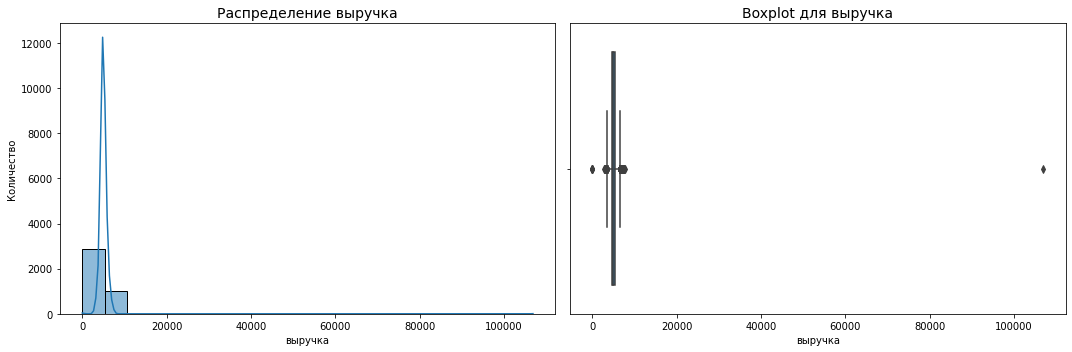

------------------------------------------------------------


In [37]:
analyze_numerical_features(market_money, ['выручка'], target=None)

In [38]:
# Найдем выброс
market_money.query('выручка >10000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [39]:
# Дропаем для точности модели 
market_money = market_money[market_money['выручка'] < 10000]

📊 Статистика для признака: выручка


count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: выручка, dtype: float64

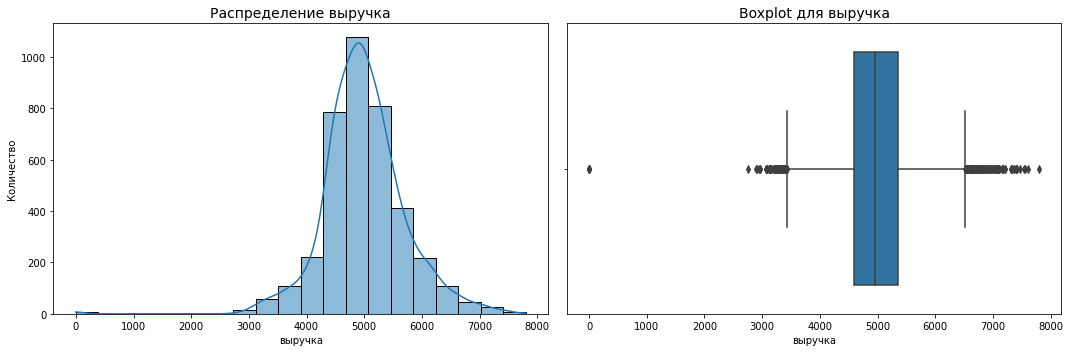

------------------------------------------------------------


In [40]:
analyze_numerical_features(market_money, ['выручка'], target=None)

#### Все не укладывается в межкваритильный размах и есть выбросы у нуля. Но их мы обрежем чуть позже.

### Теперь market_time

In [41]:
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

📊 Статистика для признака: минут


count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

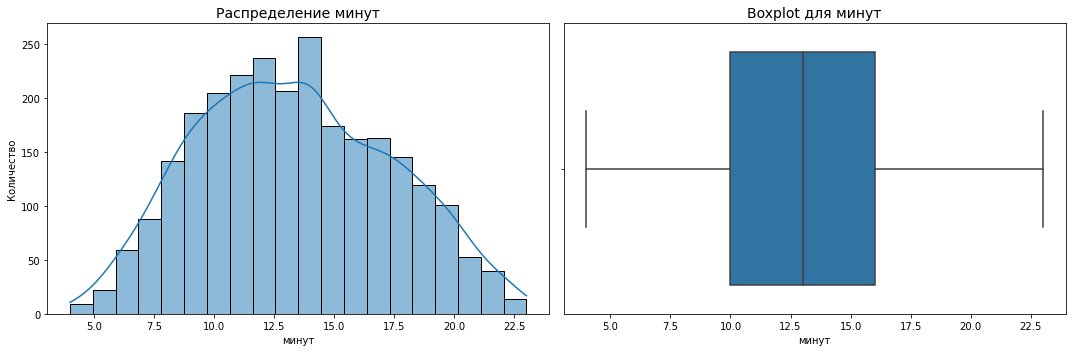

------------------------------------------------------------


In [42]:
analyze_numerical_features(market_time, ['минут'], None)


#### Преимущественно нормальное расределение  с чуть смещенной вершиной, но при этом все данные четко укладываются в межкваритьльный размах.



📊 Анализ признака: маркет_актив_6_мес
Shapiro-Wilk test: stat=0.978, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


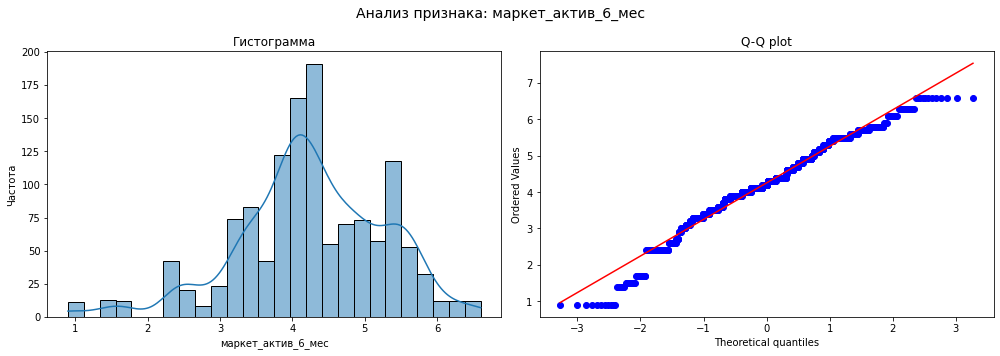


📊 Анализ признака: длительность
Shapiro-Wilk test: stat=0.973, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


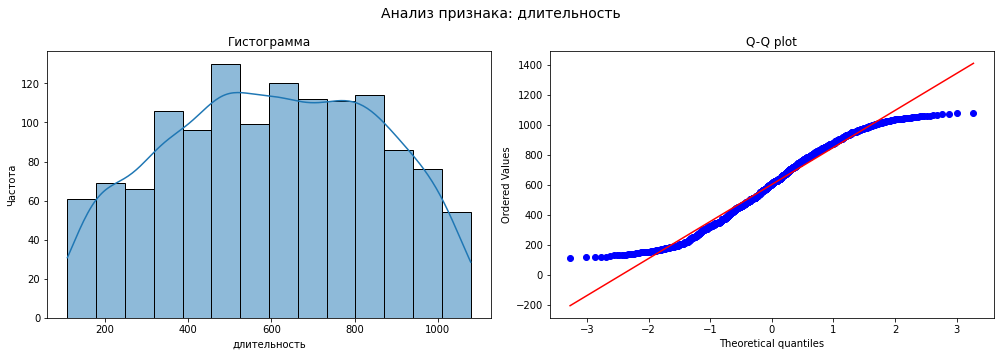


📊 Анализ признака: акционные_покупки
Shapiro-Wilk test: stat=0.662, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


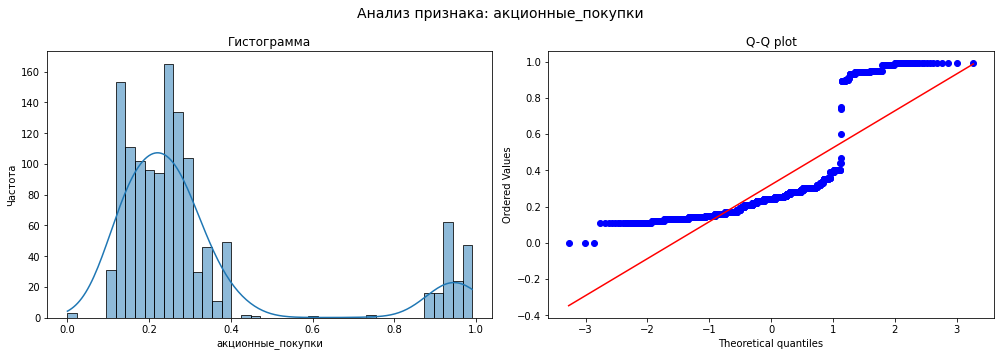


📊 Анализ признака: ошибка_сервиса
Shapiro-Wilk test: stat=0.966, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


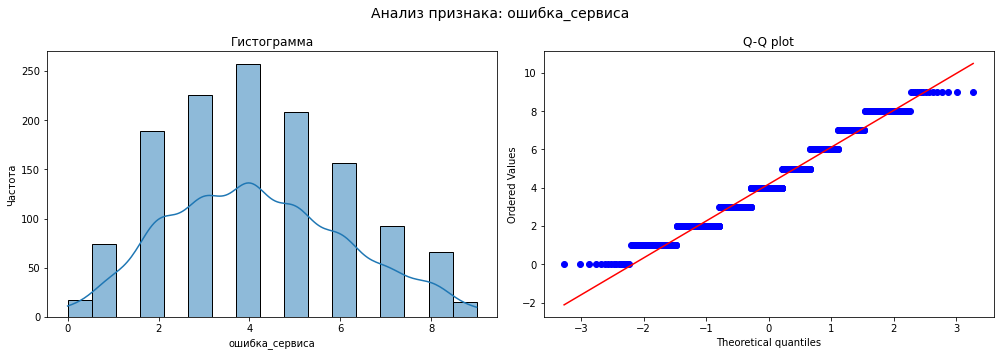


📊 Анализ признака: страниц_за_визит
Shapiro-Wilk test: stat=0.974, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


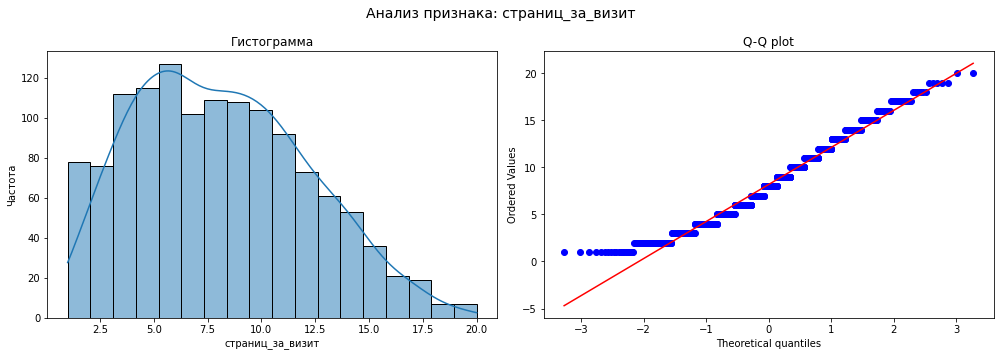

In [43]:
#проведу все тесты рядом с замечанием, что бы удобно было. Первый файл market_file
norm_test_all(market_file,quant_features)


📊 Анализ признака: выручка
Shapiro-Wilk test: stat=0.959, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


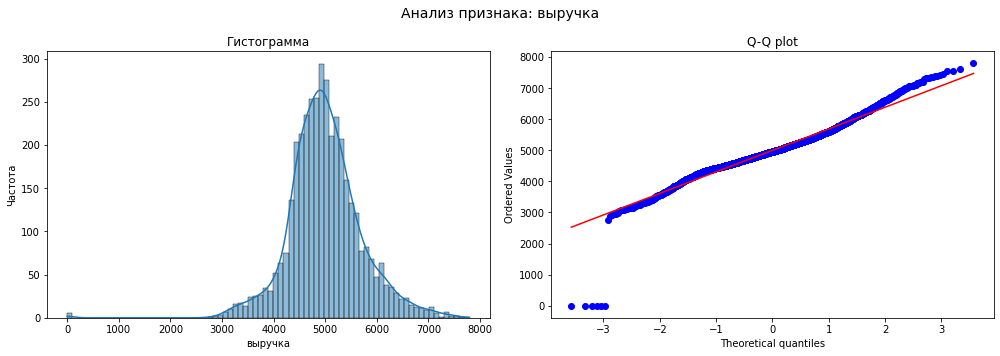

In [44]:
norm_test_all(market_money,['выручка'])


📊 Анализ признака: минут
Shapiro-Wilk test: stat=0.983, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


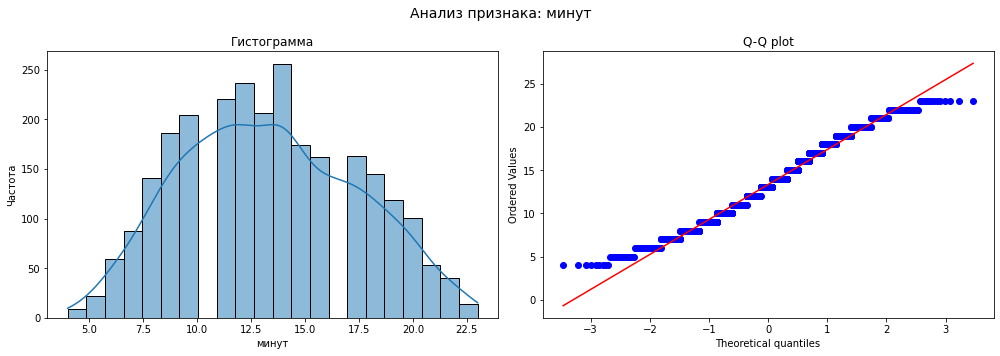

In [45]:
norm_test_all(market_time,['минут'])


📊 Анализ признака: прибыль
Shapiro-Wilk test: stat=0.998, p-value=0.258
✅ Распределение похоже на нормальное (не отвергаем H0)


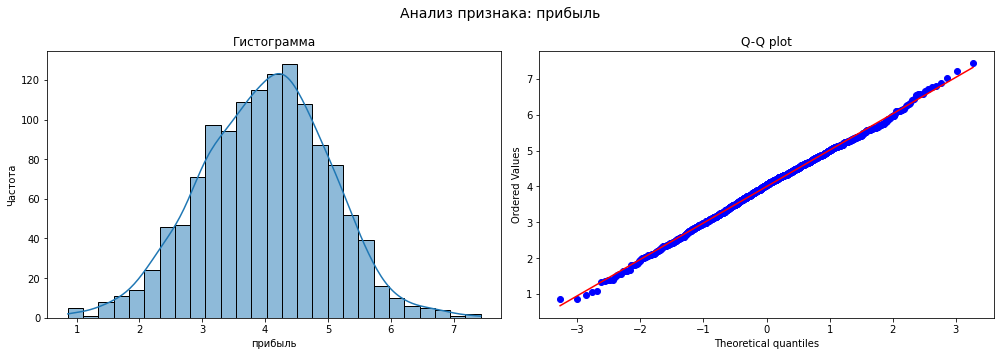

In [46]:
norm_test_all(money,['прибыль'])

### Вывод 
- Только акционные_покупки сильно далеко от значение '1'(че ближе к 1, тем более нормальное распределение)
- Только значение прибыль имеет нормальноераспределение.
- Остальные количественные признаки близки к нормальному распределению. 
- В дальнешем я буду переберать несколько моделей МО для решения задачи, что позволит выбрать лучшую модель.


### Теперь money

📊 Статистика для признака: прибыль


count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

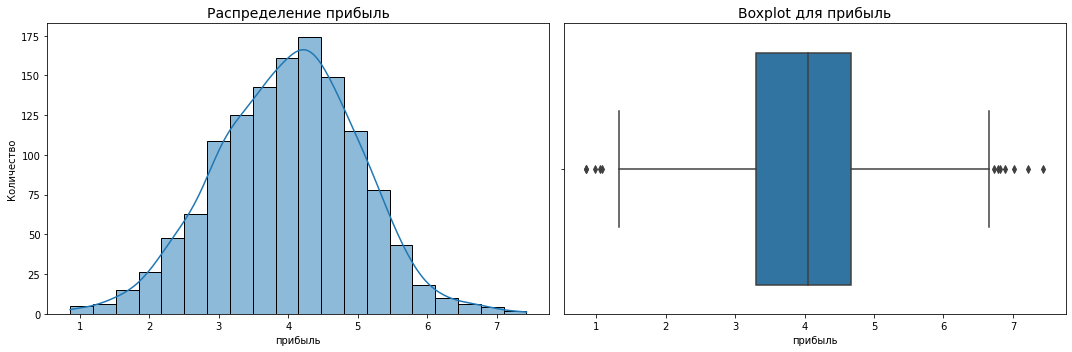

------------------------------------------------------------


In [47]:
analyze_numerical_features(money, ['прибыль'], None)

#### Преимущественно нормальное расределение, есть выбросы, но мы пока их оставим.

###  Теперь отберем клиентов с  покупательской активностью не менее трёх месяцев. Исходя из данных датасетов, это клиенты, которые есть в market_money, так как там всего 3 временных критерия: 'препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц' и у которых в каждом месяце есть выручка.


In [48]:
market_money.query('выручка == 0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [49]:
# можем дропать их
market_money = market_money[market_money['выручка'] > 0]

In [50]:
# Посчитаем количество месяцев с выручкой > 0 для каждого клиента
active_clients = (
    market_money
    .groupby('id')['период']
    .nunique()
    .reset_index(name='active_months')
)

In [51]:
# Теперь отберем клиентов у которых она равна 3м
active_clients = active_clients[active_clients['active_months'] == 3]

In [52]:
active_ids = active_clients['id']

In [53]:
# Обновим основной файл
market_file = market_file[market_file['id'].isin(active_clients['id'])]

In [54]:
len(market_file)

1296

#### Вывод:
- Познакомились с данными визуально, как с категориальными, так и с количественными. 
- Распределения нормальные, подозрений не вызывают. Хотя есть местами выбросы. 
- Убрали трех клиентов, у которых покупательская активность менее трех месяцев и один явный выброс. 


#### Обновленный вывод: 
#####  Характеристики клиента
- 

#### Поведение
- *длительность* - визуально нет различий.
- *акционные_покупки* - есть ощутимый скачок у категории со снижением активности в сторону акционных покупок. Явно ощущается, что пользователи, у которых снизилась активность покупают только по акции.
- *средний_просмотр_категорий_за_визит* - мода = значению 3. Все что меньше - в зоне риска, все что больше - там активность на прежднем уровне.
- *страниц_за_визит* - четко прослежтвается, что покупатели с высоким уровнем активности, посещают больше страниц. В то же время, покупатели со сниженной активностью, посещают в основном, не  более 5 страниц. Хороший маркер по снижению активности. 
#### Покупки
- *неоплаченные_продукты_штук_квартал* - наблюдается, что чем больше покупок неоплаченно, тем ниже активность. При этом даже у тех пользователей, у которых активность на прежднем уровне, есть до 5 товаров в квартал неоплаченных. С этим можно поработать: уведомления, геймификация. 
- *популярная категория* - самая популярная - товары для детей, самая непопулярная - кухонная посуда. 
#### Проблемы
- *ошибка_сервиса* - самое частое значение 4, распредленеи по катагориям пропроциональное. Но я считаю что ошибок много, есть с чем работать. 
#### Маркетинг 
- *маркет_актив_6_мес* - стоит обратить внимание, что с теми покупателями у кого снизилась, взаимодействий за период менее 4
- *маркет_актив_тек_мес* - как-будто одинаковое распределение. Это дает рассуждения о том, что взаимодействовать надо вдолгую, а не только в текущем месяце.


## Объединение таблиц

In [55]:
# групируем первый датасет по id и переиоду
market_money_grouped = market_money.pivot(index='id', columns='период', values='выручка')
market_money_grouped = market_money_grouped[['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']]
market_money_grouped.columns = ['выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий']

In [56]:
# теперь второй
market_time_grouped = market_time.pivot_table(index=['id'], columns=["период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_grouped['id'] = market_time_grouped.index


In [57]:
# теперь собираем воедино:
market_full = market_file.join(market_money_grouped, on='id', lsuffix="_left", rsuffix="_выручка")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.join(market_time_grouped, on='id', lsuffix="_left", rsuffix="_минут")
market_full = market_full.rename(columns={'id_left':'id'})
market_full.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий_месяц,минут_текущий_месяц,id_минут
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,215349
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,215350
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,215351
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,215352
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,215353


#### Вывод: 
- Мы создаем общую сводную таблицу где мастер-записью является id клиента, а каждая колонка это один из периодов выручки.
- Так же поступаем с таблицей где есть учет времени проведенного на сайте пользователем. 
-  Далее объединяем это все в один датасет.

In [58]:
market_full.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий_месяц,минут_текущий_месяц,id_минут
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,215349
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,215350
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,215351
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,215352
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,215353


##  Корреляционный анализ

### Сначала посмотрим общую матрицу корреляции. 
- Устраним мультиколлинеарность(при коэффиценте выше 0.8)
- Удалим некоррелирующие с целевым признаки
- Сделаем выводы перед машинным обучением. 

In [59]:
# выделим только количественные, убрав id и целевой
numeric_features = market_full.select_dtypes(include='number').drop(['id'], axis=1)


In [60]:
numeric_features = numeric_features.drop('id_минут', axis=1)

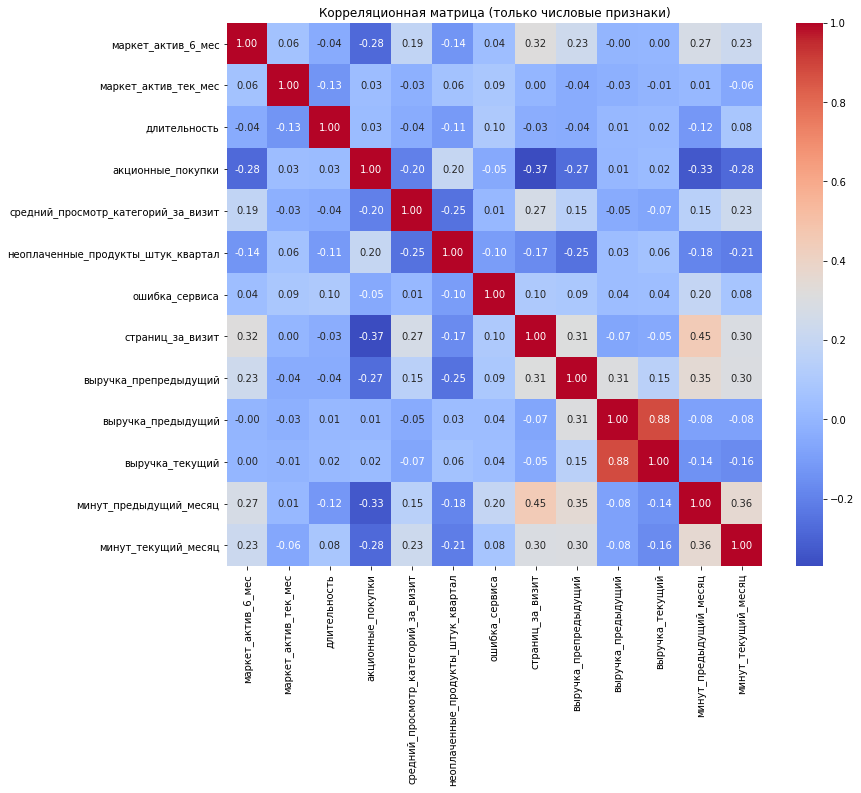

In [61]:
# строим корреляционную матрицу с учетом рекомендации
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица (только числовые признаки)')
plt.show()


interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


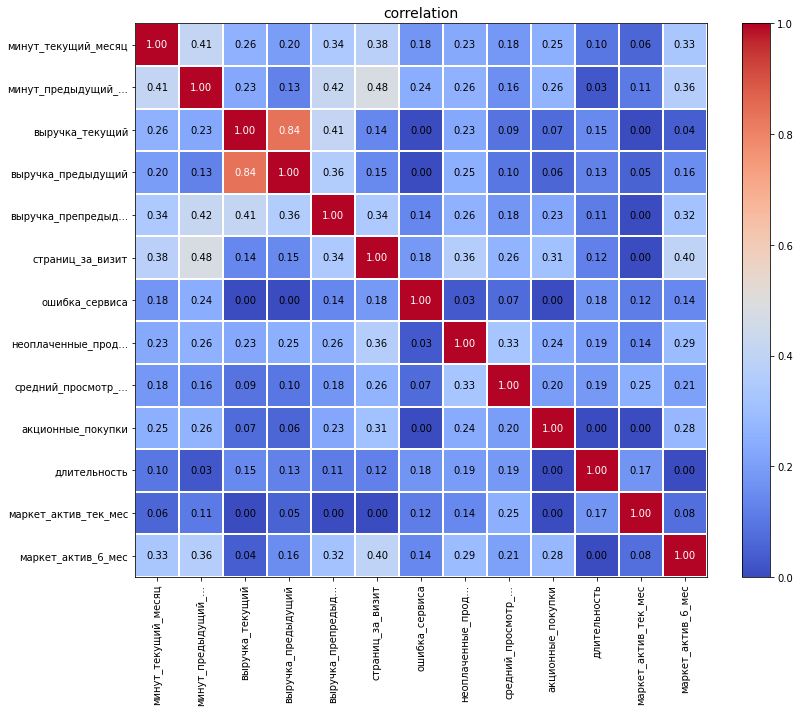

In [62]:
#попробуем по рекомендации через phik

phik_matrix = numeric_features.phik_matrix()
plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        figsize=(12, 10), 
                        vmin=0, vmax=1, color_map='coolwarm')

### Вывод по корреляции:
- Большой корреляции, которую необходимо удалить нет ни в корреляции Спирмана, при использовании phi-корреляции. 

In [63]:
# Видим что действительно большой коэффицент получился только у признаков : 'выручка_текущий','выручка_предыдущий'
# он равен: 0.84. Можем удалить его для большей точности модели. Удалим предидущий, так как он дальше от событий реального времени. 
#market_full = market_full.drop('выручка_предыдущий', axis=1)

##  Использование пайплайнов

### Будем использовать изученные ранее модели:
- Модель логистической регрессии
- Метод опорных векторов
- Метод k-ближайших соседей
- Дерево решений

### План
- Закодируем целевой признак - покупательская_активность.  
- Сделаем из акционных покупок - категориальный признак.
- Разделим данные на тренировочную и тестовую выборки.
- Подготовим данные: отдельно обработаем количественные, отдельно категориальные. 
- Масштабируем данные
- Обучим модель, посмотрим метрики, выберем самую эффективную модель.


#### Кодируем целевой и делаем категориальный из акционного

In [64]:
#market_full['активность_bin'] = market_full['покупательская_активность'].map({
#    'Снизилась': 0,
#    'Прежний уровень': 1
#})

In [65]:
# Добавляем LE и применяем
target_encoder = LabelEncoder()
market_full['активность_bin'] = target_encoder.fit_transform(market_full['покупательская_активность'])


In [66]:
market_full['активность_bin'].sample(5)

115     1
62      1
334     1
1044    0
849     0
Name: активность_bin, dtype: int64

In [67]:
market_full['акционные_покупки_категория'] = market_full['акционные_покупки']\
.apply( lambda x: 'Часто покупает по акции' if x>= 0.5 else 'Редко покупает по акции' )
market_full = market_full.drop(['акционные_покупки'], axis=1)

In [68]:
market_full['акционные_покупки_категория'].sample(5)

1287    Редко покупает по акции
985     Редко покупает по акции
163     Редко покупает по акции
1266    Редко покупает по акции
345     Редко покупает по акции
Name: акционные_покупки_категория, dtype: object

#### Разделение данных

In [69]:
X = market_full.drop(['id', 'покупательская_активность', 'активность_bin','id_минут'], axis=1)
y = market_full['активность_bin']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


In [70]:
X_train.head()


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
510,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,4347.0,5170.5,6014.2,20,6,Редко покупает по акции
13,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,4597.0,6400.0,3789.7,11,13,Редко покупает по акции
536,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4626.0,4113.0,3798.4,13,10,Редко покупает по акции
1216,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,5269.0,4930.0,4766.2,14,19,Часто покупает по акции
367,премиум,да,3.6,5,873,Товары для детей,3,2,2,5,4691.0,3716.0,4600.0,10,10,Редко покупает по акции


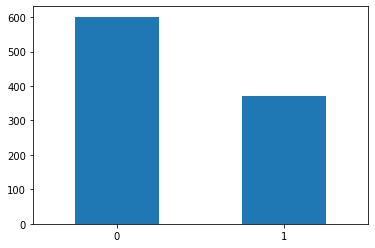

In [71]:
# Посмотрим на распределение целевого признака
y_train.value_counts().plot(kind='bar', rot=0)
plt.show()

#### Обработка данных

In [72]:
print(X_train.columns, X_test.columns)

Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий',
       'выручка_текущий', 'минут_предыдущий_месяц', 'минут_текущий_месяц',
       'акционные_покупки_категория'],
      dtype='object') Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий',
       'выручка_текущий', 'минут_предыдущий_месяц', 'минут_текущий_месяц',
       'акционные_покупки_категория'],
      dtype='object')


In [73]:
# сделаем списки с названими признаков:
ohe_columns = [
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория'
]

ord_columns = [
    'акционные_покупки_категория'
]

num_columns = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'выручка_препредыдущий',
    'выручка_текущий',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц'
]

In [74]:
# Настроим первый этап, OHE-кодирование - заменим пропуски на самое частое значение
# закодируем категориальные признаки в бинарные
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

In [75]:
# Следующий этап, переходим к Ordinal-кодированию, заменяем пропуски на самые частые значения
# Кодируем категорияальные признаки в числовой формат, понятный МО 
# После кодирования заполняем пропуски самым частым значением 
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['Редко покупает по акции','Часто покупает по акции']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [76]:
# Собираем дальше все этапы предобработки:
# ohe - категориальные признаки
# ord - порядковые признаки
# num - масштабируем числовые признаки
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [77]:
# Финалим, собираем пайплайн. Пока прописываем древо дефолтно, дальше будем перебирать.
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [78]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [79]:
#Запускаем поиск рандомный 
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

### Метрика ROC AUC выбрана потому, что:
 - устойчиво работает при дисбалансе классов, который у нас имеется
 - оценивает качество ранжирования модели 
 - не зависит от выбранного порога вероятности, который пришлось бы искать.
 - Таким образом, она является оптимальной метрикой для нашей ситуации

In [80]:
# Обучаем
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['тип_сервиса',
                                                                                'разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeli...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [81]:
# Выводим предметные итоги:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(ste

In [82]:
# проверим работу модели на тестовой выборке
# и сделаем прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.92


In [83]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_test_pred, average="macro"), 2)}')


Метрика F1-score на тестовой выборке: 0.9


### Вывод: 
- Мы перебрали 4 модели(KNN, Decision Tree, SVC, Logistic Regression), самая эффективаная - модель логистической регрессии.
- Лучшие параметры: LogisticRegression(C=4, penalty='l1', random_state=42,solver='liblinear')
- Ее метрика ROC_AUC на тренировочной выборке: 0.91
- Эта же мтерка на тестовой выборке = 0.89
- F1-score на тестовой равна 0.85. 
- Поскольку классы несбалансированы, метрика F1-score была рассчитана с усреднением macro, чтобы одинаково учитывать качество классификации каждого класса
- Это достоточно хорошие  результаты, модель можно использовать. 

## Анализ важности признаков

/opt/conda/lib/python3.9/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


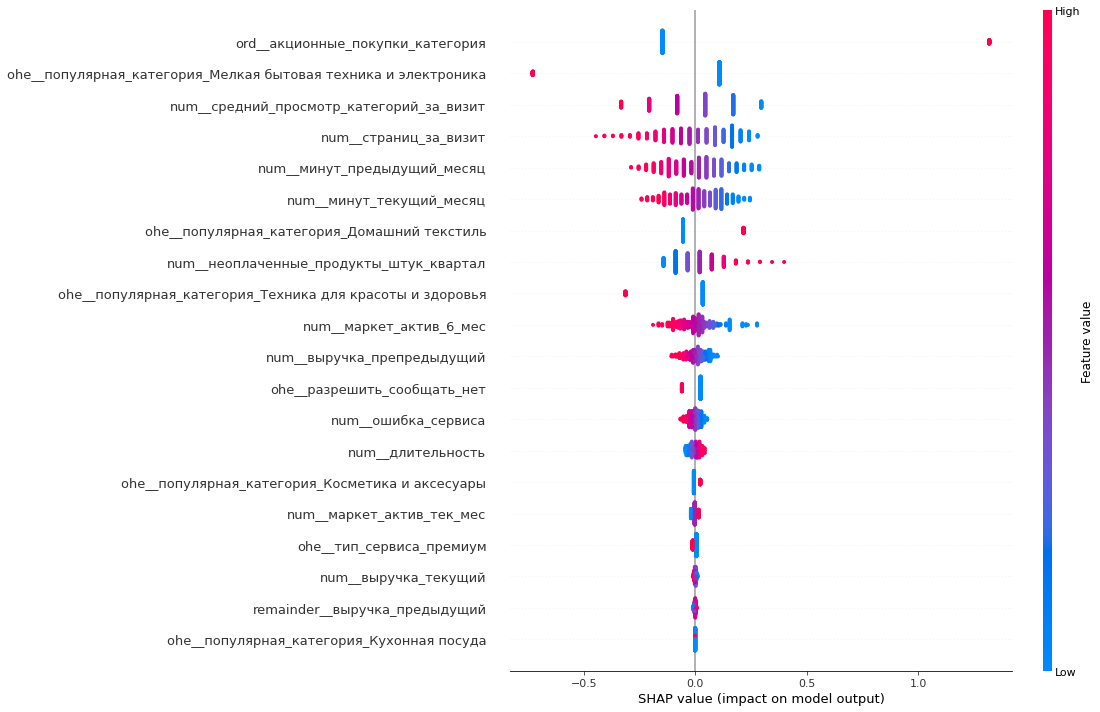

In [84]:
# Преобразуем обучающие данные с препроцессором
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

# Получаем модель из пайплайна
model = randomized_search.best_estimator_.named_steps['models']

# Создаем объяснитель
explainer = shap.LinearExplainer(model, X_train_2, feature_perturbation="interventional")

# Преобразуем тестовые данные
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

# Получаем имена признаков
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2_df = pd.DataFrame(X_test_2, columns=feature_names)

# Вычисляем значения SHAP
shap_values = explainer.shap_values(X_test_2)

# Строим диаграмму важности признаков
shap.summary_plot(shap_values, X_test_2_df, feature_names=feature_names,plot_size=(16, 10))

### Вывод:
- Самым сильновлияющим стал признак 'акционные покупки - категория'. Есть у меня подозрение, что я зря его сделал категориальным. Надеюсь, ревьюер меня поправит если что. 
- Чуть меньшее влияние оказывают признаки: Категория мелкая бытовая техника,домашний текстиль исредний просмотр категорий за визит.

## Сегментация покупателей:


### У нас есть разбиение на тех клиентов у кого снизилась покупательская активность и на тех, у кого осталась на прежнем уровне. Соеденим их с данными о прибыльности.



In [85]:
# Соберем результаты
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [86]:
# Cохранимся и объеденимся
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_остаться_активным'] = y_test_proba
X_train_full['вероятность_остаться_активным'] = y_train_proba
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)
df_full = pd.concat([X_train_full, X_test_full])
df_full['активность_bin'] = y_all
df_full = df_full.join(money)

In [87]:
df_full.columns

Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий',
       'выручка_текущий', 'минут_предыдущий_месяц', 'минут_текущий_месяц',
       'акционные_покупки_категория', 'вероятность_остаться_активным',
       'активность_bin', 'id', 'прибыль'],
      dtype='object')

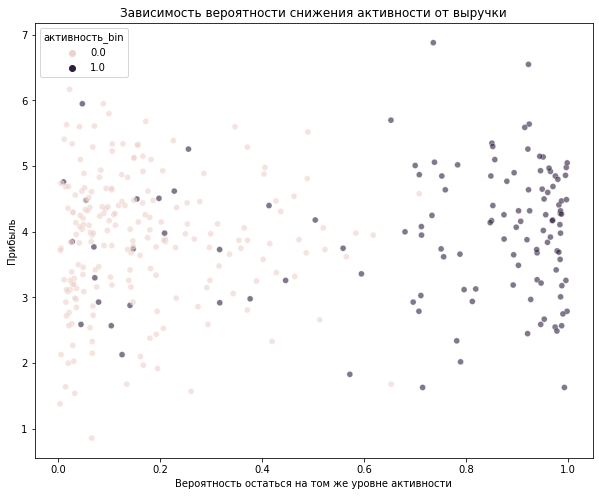

In [88]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df_full, y='прибыль', x='вероятность_остаться_активным', hue=y_test, alpha=0.6)
plt.xlabel('Вероятность остаться на том же уровне активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от выручки')
plt.show()

####  Наглядно видно, что модель хорошо предсказывает. Но прибыль напрямую не коррелирует с вероятностью снижения.  Есть клиенты с высокой прибылью, но при этом и предсказание модели, и по факту их активность снизилась.Имеем биномиальное распределение (0 или 1) . Нам необходимо сфокусироваться на клиентах с высокой вероятностью снижения. Тех, кто близок к снижению активности(значения ниже 0,5) и тех кто приносит прибыль(значения выше 3)

In [89]:
valuable_at_risk = df_full[
    (df_full['вероятность_остаться_активным'] < 0.5) &
    (df_full['прибыль'] > 3)
]

print(f"Количество клиентов в сегменте: {len(valuable_at_risk)}")
display(valuable_at_risk.describe())

Количество клиентов в сегменте: 716


,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий_месяц,минут_текущий_месяц,вероятность_остаться_активным,активность_bin,id,прибыль
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,713.000000,716.000000,716.000000
mean,4.586313,4.002793,591.237430,3.659218,2.273743,4.350559,9.885475,4943.502793,4930.335894,5182.623045,15.184358,14.840782,0.148636,0.378682,216175.335196,4.307975
std,0.832341,0.679360,254.206385,1.287296,1.501676,1.967217,3.432589,318.754532,617.862598,793.743946,3.383147,3.946114,0.127754,0.485399,272.584572,0.786336
min,1.500000,3.000000,121.000000,1.000000,0.000000,0.000000,3.000000,4339.000000,3111.000000,2952.200000,7.000000,4.000000,0.002772,0.000000,215350.000000,3.030000
25%,4.000000,4.000000,386.250000,3.000000,1.000000,3.000000,7.000000,4702.250000,4528.625000,4721.500000,13.000000,12.000000,0.046849,0.000000,215958.750000,3.700000
50%,4.400000,4.000000,594.000000,4.000000,2.000000,4.000000,10.000000,4940.500000,4973.250000,5110.450000,15.000000,15.000000,0.105358,0.000000,216178.500000,4.260000
75%,5.300000,4.000000,795.250000,5.000000,3.000000,6.000000,12.000000,5176.000000,5339.625000,5607.700000,18.000000,18.000000,0.209137,1.000000,216406.250000,4.820000
max,6.600000,5.000000,1061.000000,6.000000,7.000000,9.000000,20.000000,5663.000000,6588.500000,7557.000000,23.000000,23.000000,0.497699,1.000000,216646.000000,7.020000


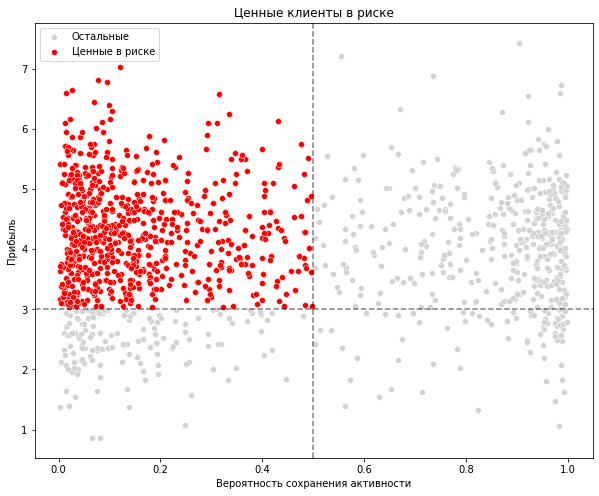

In [90]:
# Отлтично, визуализируем 
plt.figure(figsize=(10, 8))

# Общий фон — все клиенты
sns.scatterplot(data=df_full, x='вероятность_остаться_активным', y='прибыль', color='lightgray', label='Остальные')

# Целевой сегмент
sns.scatterplot(data=valuable_at_risk, x='вероятность_остаться_активным', y='прибыль', color='red', label='Ценные в риске')

plt.axvline(0.5, linestyle='--', color='black', alpha=0.5)
plt.axhline(3, linestyle='--', color='black', alpha=0.5)

plt.xlabel('Вероятность сохранения активности')
plt.ylabel('Прибыль')
plt.title('Ценные клиенты в риске')
plt.legend()
plt.show()

In [91]:
# добавим сегмент ценных стабильных клиентов, у которых низкая вероятность снижения
valuable_stable = df_full[
    (df_full['вероятность_остаться_активным'] >= 0.5) &
    (df_full['прибыль'] > 3)
]

In [92]:
# и остальные 
others = df_full[~df_full.index.isin(valuable_at_risk.index) & ~df_full.index.isin(valuable_stable.index)]


In [93]:
print("🧮 Средние значения признаков тех, кто в риске:")
display(valuable_at_risk.describe().T[['mean', 'std']])
print("🧮 Средние значения признаков тех, кто стабилен и ценен:")
display(valuable_stable.describe().T[['mean', 'std']])


🧮 Средние значения признаков тех, кто в риске:


,mean,std
маркет_актив_6_мес,4.586313,0.832341
маркет_актив_тек_мес,4.002793,0.679360
длительность,591.237430,254.206385
средний_просмотр_категорий_за_визит,3.659218,1.287296
неоплаченные_продукты_штук_квартал,2.273743,1.501676
ошибка_сервиса,4.350559,1.967217
страниц_за_визит,9.885475,3.432589
выручка_препредыдущий,4943.502793,318.754532
выручка_предыдущий,4930.335894,617.862598
выручка_текущий,5182.623045,793.743946


🧮 Средние значения признаков тех, кто стабилен и ценен:


,mean,std
маркет_актив_6_мес,3.587569,1.007746
маркет_актив_тек_мес,4.013812,0.707950
длительность,629.027624,235.621285
средний_просмотр_категорий_за_визит,2.464088,1.136200
неоплаченные_продукты_штук_квартал,4.038674,2.206424
ошибка_сервиса,3.850829,1.916501
страниц_за_визит,4.698895,2.537355
выручка_препредыдущий,4622.549724,260.869055
выручка_предыдущий,4954.350829,826.436748
выручка_текущий,5315.901934,900.025260


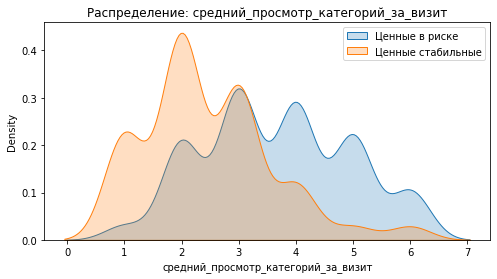

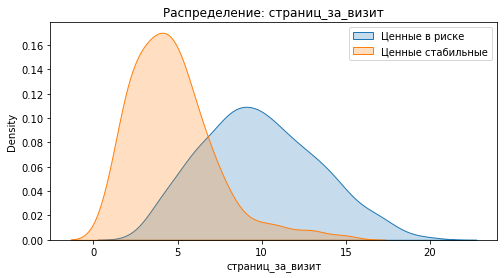

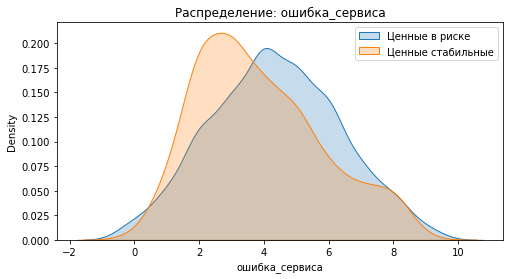

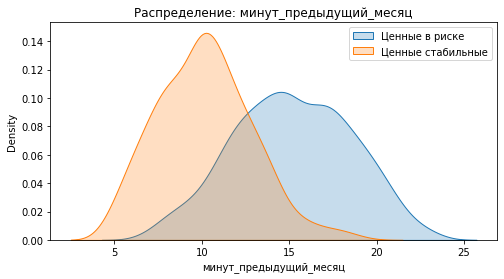

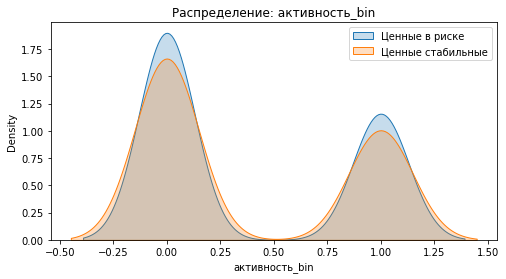

In [94]:
key_features = [
    'средний_просмотр_категорий_за_визит',
    'страниц_за_визит',
    'ошибка_сервиса',
    'минут_предыдущий_месяц',
    'активность_bin'
]

for feature in key_features:
    if feature in df_full.columns:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(valuable_at_risk[feature], label='Ценные в риске', fill=True)
        sns.kdeplot(valuable_stable[feature], label='Ценные стабильные', fill=True)
        plt.title(f'Распределение: {feature}')
        plt.legend()
        plt.show()
    else:
        print(f"[⚠️ Пропущено] Признак отсутствует в данных: {feature}")

### Вывод, исходя из данных, мы можем сделать выводы:
- Клиенты в риске изучают меньше категорий, у них неже вовлеченность. Это может быть маркером.
- Количество просмотренных страниц за визит так же явно меньше. 
- Проводят меньше времени за платформой. 
- Стабильные клиенты чаще получают маркетинг. 

### Рекомендации бизнесу по работе с рисковым сегментом:
- Активизировать маркетинговые кампании
- Оптимизировать путь к покупке,выяснить причину неоплачиваемости товаров.
- Увеличить вовлеченность клиентов.
- Поработать с категориями товаров.

## Общий вывод
В рамках данного проекта решалась задача определения покупателей интернет-магазина «В один клик», чья активность может снизиться. Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

### Что было сделано:

####  Осуществлена загрузка 4х датасетов с данными о компании и первоначальное знакомство с ними

#### Проведена предобработка данных:
- Привели все столбцы к единообразию
- Убрали ошибку в категориях
- Убедились что нет дубликатов

#### Проведен исследовательский анализ данных, в рамках его:
- Познакомились с данными визуально, как с категориальными, так и с количественными. 
- Распределения нормальные, подозрений не вызывают. Хотя есть местами выбросы. 
- Убрали трех клиентов, у которых покупательская активность менее трех месяцев и один явный выброс. 

#### Объеденили 3 таблицы для дальшенего МО. 
- Мы создали общую сводную таблицу где мастер-записью является id клиента, а каждая колонка это один из периодов выручки.
- Так же поступаем с таблицей где есть учет времени проведенного на сайте пользователем. 
-  Далее объединяем это все в один датасет.

#### Провели корреляционный анализ:
- Устранили мультиколлинеарность, убрав один из более старых признаков. 
- Тк датасет не большой, оставили все признаки, даже с маленькой корреляцией.

#### Собрали пайплайн данных
##### Использовали модели: 
- Модель логистической регрессии
- Метод опорных векторов
- Метод k-ближайших соседей
- Дерево решений
##### Действовали по плану:
- Закодируем целевой признак - покупательская_активность.  
- Сделаем из акционных покупок - категориальный признак.
- Разделим данные на тренировочную и тестовую выборки.
- Подготовим данные: отдельно обработаем количественные, отдельно категориальные. 
- Масштабируем данные
- Обучим модель, посмотрим метрики, выберем самую эффективную модель.
##### По итогу:
- Мы перебрали 4 модели(KNN, Decision Tree, SVC, Logistic Regression), самая эффективаная - модель логистической регрессии.
- Лучшие параметры: LogisticRegression(C=4, penalty='l1', random_state=42,solver='liblinear')
- Ее метрика ROC_AUC на тренировочной выборке: 0.91
- Эта же мтерка на тестовой выборке = 0.89
- F1-score на тестовой равна 0.85. 
- Поскольку классы несбалансированы, метрика F1-score была рассчитана с усреднением macro, чтобы одинаково учитывать качество классификации каждого класса
- Это достоточно хорошие  результаты, модель можно использовать. 

#### Проанализировали важность признаков: 
- Самым сильновлияющим стал признак 'акционные покупки - категория'.
- Чуть меньшее влияние оказывают признаки: Категория мелкая бытовая техника,домашний текстиль исредний просмотр категорий за визит.

#### Сегментировали пользователей
- Добавили к единой таблице еще одну, с прибылью.
- Сначала визуализировали и еще раз наглядно убедились в точности модели.
- Далее обратили внимание, что активность слабо коррелирует с прибылью
- Есть клиенты с высокой прибылью, но при этом и предсказание модели, и по факту их активность снизилась.Имеем биномиальное распределение (0 или 1) . 
- Решили, что нам необходимо сфокусироваться на клиентах с высокой вероятностью снижения. Тех, кто близок к снижению активности(значения ниже 0,5) и тех кто приносит прибыль(значения выше 3)¶

